In [17]:
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib
#%matplotlib notebook

import pandas as pd

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

from matplotlib.pyplot import cm
mpl_colors = iter(cm.rainbow(np.linspace(0, 1, 400)))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def density_scatter(x, y, bins=50, xlim=None, ylim=None, filename=None):
    fig = plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
import matplotlib.animation as animation

In [216]:
def get_image_data(filename, gamma=0.6, debug=False, hide_max=False, logscale=False):
    with open(filename, "rb") as f:
        image_size = np.fromfile(f, dtype=np.int32, count=2)
        extent = np.fromfile(f, dtype=np.float32, count=4)
        image = np.fromfile(f, dtype=np.int32).reshape(image_size).T.astype(np.float)

        if (debug):
            _all = image.shape[0] * image.shape[1]
            _z = image[image == 0].shape[0]
            print(f"{filename}")
            print(f"\tzeros: {_z} ({100 * _z/_all}%)")
            print(f"\tmean & std: {np.mean(image)} +- {np.std(image)}")
            print(f"\ttotal_rays: {np.sum(image)}")

        img = np.zeros_like(image)
        if gamma is not None:
            img[image > 0] = image[image > 0]**gamma
        if logscale is not None and logscale:
            img[image > 0] = np.log10(image[image > 0])
        if img[img == np.max(img)].shape[0] < 5 and hide_max:
            img[img == np.max(img)] = np.mean(img) # removing center-of-mass pixel with extreame amplification
        return img, extent

def get_lc_data(filename, gamma=0.6, debug=False, hide_max=False, logscale=False):
    with open(filename, "rb") as f:
        lcs_columns = np.fromfile(f, dtype=np.int32, count=1)[0]
        lcs_t_steps = np.fromfile(f, dtype=np.int32, count=1)[0]
        lcs_sources = np.fromfile(f, dtype=np.float32, count=3)
        lcs_eccentricities = np.fromfile(f, dtype=np.float32, count=3)
        lcs_data = np.fromfile(f, dtype=np.float32).reshape((lcs_t_steps, lcs_columns)).astype(np.float)
        labels=['t', 'y1', 'y2']
        lcs = ['ad', 'gs', 'ld', 'pl']
        lcs_el = ['el', 'el_orth']
        sources = []
        eccentricities = []
        for s in np.arange(*lcs_sources).astype(np.float):
            s = ('%f' % s).rstrip('0').rstrip('.')
            sources.append(s)
            for l in lcs:
                labels.append("%s_r%s" % (l, s))
            for e in np.arange(*lcs_eccentricities).astype(np.float):
                e = ('%f' % e).rstrip('0').rstrip('.')
                for l in lcs_el:
                    labels.append("%s_r%s_e%s" % (l, s, e))                    
        for e in np.arange(*lcs_eccentricities).astype(np.float):
            e = ('%f' % e).rstrip('0').rstrip('.')
            eccentricities.append(e)
        df = pd.DataFrame(data=lcs_data.copy(), columns=labels)
        df.attrs['lcs_columns'] = lcs_columns
        df.attrs['lcs_t_steps'] = lcs_t_steps
        
        df.attrs['lcs_sources'] = lcs_sources
        df.attrs['lcs_eccentricities'] = lcs_eccentricities
        df.attrs['models'] = lcs
        df.attrs['models_el'] = lcs_el
        df.attrs['sources'] = sources
        df.attrs['eccentricities'] = eccentricities
        return df

In [187]:
def autoscale_y(ax,margin=0.1):
    """This function rescales the y-axis based on the data that is visible given the current xlim of the axis.
    ax -- a matplotlib axes object
    margin -- the fraction of the total height of the y-data to pad the upper and lower ylims"""

    import numpy as np

    def get_bottom_top(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo,hi = ax.get_xlim()
        y_displayed = yd[((xd>lo) & (xd<hi))]
        h = np.max(y_displayed) - np.min(y_displayed)
        bot = np.min(y_displayed)-margin*h
        top = np.max(y_displayed)+margin*h
        return bot,top

    lines = ax.get_lines()
    bot,top = np.inf, -np.inf

    for line in lines:
        new_bot, new_top = get_bottom_top(line)
        if new_bot < bot: bot = new_bot
        if new_top > top: top = new_top

    ax.set_ylim(bot,top)

In [188]:
def cross_corr(t, y1, y2):
    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    #corr = np.correlate(y1, y2, mode='same')
    #unbiased_sample_size = np.correlate(np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = signal.correlate(y1, y2)
    unbiased_sample_size = signal.correlate(np.ones(len(y1)), np.ones(len(y1)))
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    res = corr[(len(corr) // 2) : len(corr)]
    return res, t.to_numpy()[:len(res)]

def acorr_zh(t, sig, avg_substracted=True):
    k = sig
    N = len(sig)
    m = int(N/2)
    if avg_substracted:
        k = sig - np.mean(sig)
    acf = []
    for i in range(0, m, 1):
        kt = np.pad(k, (i, 0), 'constant', constant_values=0)[:len(k)]
        kt2 = np.power(np.pad(k, (int(i/2), 0), 'constant', constant_values=0)[:len(k)], 2)
        acf.append(np.sum(k * kt) / np.sum(kt2))
    acf = np.array(acf)
    lag = np.arange(m) * (t[1] - t[0])
    return lag, acf

In [8]:
if False:
    rays_y = np.loadtxt("./output/test/rays_0.00.dat")
    m = np.logical_and(np.abs(rays_y[:,0]) <= 100, np.abs(rays_y[:,1]) <= 100)
    x = rays_y[:,0][m]
    y = rays_y[:,1][m]
    density_scatter(x, y, bins=[200, 200])

In [9]:
if False:
    filename1 = "output/test1234567890/image_0.00.dat"
    filename2 = "output/test1234567890/image_0.00.dat"

    img1, extent1 = get_image_data(filename1, gamma=1, debug=True)
    img2, extent2 = get_image_data(filename2, gamma=1, debug=True)

    fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
    pos1 = ax1.imshow(img1, interpolation='none', extent=extent1, origin='lower')
    pos2 = ax2.imshow(img2, interpolation='none', extent=extent2, origin='lower')
    ax1.set_title(filename1)
    ax2.set_title(filename2)
    fig.colorbar(pos1, ax=ax1)
    fig.colorbar(pos2, ax=ax2)
    fig.tight_layout()
    plt.show()
if False:
    filename1 = "output/reference/image_0.00.dat"
    filename2 = "output/reference/lc_0.00.dat"

    img1, extent1 = get_image_data(filename1, logscale=True, debug=True)
    lc = get_lc_data(filename2)

    fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
    pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    pos2 = ax2.plot(lc['t'], lc['a_gs'], '-', color='blue')
    ax2.plot(lc['t'], lc['a_ad'], '-', color='orange')
    ax2.plot(lc['t'], lc['a_pl'], '-', color='green')
    ax2.plot(lc['t'], lc['a_pl'], '-', color='grey')
    ax2.plot(lc['t'], lc['a_el'], '-', color='red', linestyle='dotted')
    #pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
    #pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
    ax1.set_title(filename1)
    ax2.set_title(filename2)
    fig.colorbar(pos1, ax=ax1)
    fig.tight_layout()
    plt.show()
if False:
    filename1 = "output/reference/image_0.00.dat"
    filename2 = "output/reference/lc_0.00.dat"

    img1, extent1 = get_image_data(filename1, logscale=True, debug=True)
    lc = get_lc_data(filename2)

    fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
    pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    pos2 = ax2.plot(lc['t'], lc['a_gs'], '-', label='gs')
    ax2.plot(lc['t'], lc['a_ad'], '-', label='ad')
    ax2.plot(lc['t'], lc['a_pl'], '-', label='pl')
    ax2.plot(lc['t'], lc['a_ld'], '-', label='ld')
    ax2.plot(lc['t'], lc['a_el'], '-', linestyle='dotted', label='el')
    ax2.plot(lc['t'], lc['a_el'], '-', linestyle='dashed', label='el ⊥')
    ax2.legend()
    #pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
    #pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
    ax1.set_title(filename1)
    ax2.set_title(filename2)
    fig.colorbar(pos1, ax=ax1)
    fig.tight_layout()
    plt.show()

In [1]:
if False:
    from scipy import signal
    import matplotlib.colors as mcolors

    fig, ax_corr = plt.subplots(1, 1, figsize=(9, 5))

    lags = None
    lags1 = None


    index = 0
    for e in ['0.7', '0.9']:
        a1 = []
        a2 = []

        a3 = []
        a4 = []
        for t in np.arange(0, 50, 0.1):
            if 10 * t % 10 == 0:
                print(t)

            filename2 = "output/e%s_r0.2/lc_%.2f.dat" % (e, t)
            lc = get_lc_data(filename2)

            tc = lc['t']
            sig1 = lc['a_el'] - np.mean(lc['a_el'])
            sig2 = lc['a_el_orth'] - np.mean(lc['a_el_orth'])

            #corr1, lags = cross_corr(tc, sig1, sig1)
            #corr2, lags = cross_corr(tc, sig2, sig2)
            #a1.append(corr1)
            #a2.append(corr2)

            c1 = signal.correlate(sig1, sig1)
            c2 = signal.correlate(sig2, sig2)
            c1 /= np.max(c1)
            c2 /= np.max(c2)


            lags, c1 = acorr_zh(tc, sig1)
            lags, c2 = acorr_zh(tc, sig2)

            a1.append(c1)
            a2.append(c2)

            #lags = signal.correlation_lags(len(sig1), len(sig1)) * (tc[1] - tc[0])

        step = 1

        ax_corr.errorbar(lags[::step], y=np.mean(a1, axis=0)[::step], yerr=np.std(a1, axis=0)[::step]/np.sqrt(len(a1)), c=colors[index], label='EL $\epsilon = %s$' % e)
        index+=1
        ax_corr.errorbar(lags[::step], y=np.mean(a2, axis=0)[::step], yerr=np.std(a2, axis=0)[::step]/np.sqrt(len(a2)), c=colors[index], label='EL ⊥ $\epsilon = %s$' % e)
        index+=1

    ax_corr.set_title('$R=0.2R_E$, $N=500$')
    ax_corr.set_xlabel('Lag ($R_E$)')
    ax_corr.set_ylabel('ACF')
    ax_corr.set_xlim([0, 5])
    ax_corr.autoscale_view()
    autoscale_y(ax_corr)
    fig.tight_layout()
    plt.show()

In [222]:
from scipy import signal

lags = None
lags1 = None
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
step = 5

directory='s0.2_e0.1-0.9_r0.1-0.7'

iterations = np.arange(0, 1, 0.1)
for t in iterations:
    filename_lc = f"output/{directory}/lc_%.2f.dat" % (t)
    lc = get_lc_data(filename_lc)
    for r in lc.attrs['sources']:
        e = 0.0
        print("t=%s r=%s e=%s" % (t, r, e))
        ad = lc['ad_r%s' % r]
        gs = lc['gs_r%s' % r]
        ld = lc['ld_r%s' % r]
        pl = lc['pl_r%s' % r]
        for e in lc.attrs['eccentricities']:
            el = lc['el_r%s_e%s' % (r, e)]
            el_orth = lc['el_orth_r%s_e%s' % (r, e)]
            
            
    break      
            
    filename_acf = "output/e%s_r%s/lc_%.2f.dat.acf" % (e, r, t)
    filename_acf_avg = "output/e%s_r%s/lc_%.2f.dat.acf-avg" % (e, r, t)

    for r in ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7']:    
        for e in ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']:
            print("e=%s r=%s t=%.2f" % (e, r, 0))
            c0s = []
            c1s = []
            c2s = []
            c3s = []
            c4s = []
            c5s = []

            

            tc = lc['t']
            sig0 = lc['a_ad']
            sig1 = lc['a_gs']
            sig2 = lc['a_ld']
            sig3 = lc['a_pl']
            sig4 = lc['a_el']
            sig5 = lc['a_el_orth']
            
            c0 = signal.correlate(sig0, sig0)
            c1 = signal.correlate(sig1, sig1)
            c2 = signal.correlate(sig2, sig2)
            c3 = signal.correlate(sig3, sig3)
            c4 = signal.correlate(sig4, sig4)
            c5 = signal.correlate(sig5, sig5)

            c0 /= np.max(c0)
            c1 /= np.max(c1)
            c2 /= np.max(c2)
            c3 /= np.max(c3)
            c4 /= np.max(c4)
            c5 /= np.max(c5)
            
            lags = signal.correlation_lags(len(sig0), len(sig0)) * (tc[1] - tc[0])
            mask = np.logical_and(lags >= 0, lags <= np.max(tc)/2)
            header = '# lag acf_ad acf_gauss acf_ld acf_pl acf_el acf_el_orth'
            np.savetxt(filename_acf, np.column_stack([lags, c0, c1, c2, c3, c4, c5])[mask], fmt=['%f', '%f', '%f', '%f', '%f', '%f', '%f'], header=header)

            c0 = signal.correlate(sig0 - np.mean(sig0), sig0 - np.mean(sig0))
            c1 = signal.correlate(sig1 - np.mean(sig1), sig1 - np.mean(sig1))
            c2 = signal.correlate(sig2 - np.mean(sig2), sig2 - np.mean(sig2))
            c3 = signal.correlate(sig3 - np.mean(sig3), sig3 - np.mean(sig3))
            c4 = signal.correlate(sig4 - np.mean(sig4), sig4 - np.mean(sig4))
            c5 = signal.correlate(sig5 - np.mean(sig5), sig5 - np.mean(sig5))

            c0 /= np.max(c0)
            c1 /= np.max(c1)
            c2 /= np.max(c2)
            c3 /= np.max(c3)
            c4 /= np.max(c4)
            c5 /= np.max(c5)
            
            c0s.append(c0)
            c1s.append(c1)
            c2s.append(c2)
            c3s.append(c3)
            c4s.append(c4)
            c5s.append(c5)
            
            lags = signal.correlation_lags(len(sig0), len(sig0)) * (tc[1] - tc[0])
            mask = np.logical_and(lags >= 0, lags <= np.max(tc)/2)
            header = '# lag acf_ad acf_gauss acf_ld acf_pl acf_el acf_el_orth'
            np.savetxt(filename_acf, np.column_stack([lags, c0, c1, c2, c3, c4, c5])[mask], fmt=['%f', '%f', '%f', '%f', '%f', '%f', '%f'], header=header)
        fig, ax_corr = plt.subplots(1, 1, figsize=(12, 6))
        ax_corr.errorbar(lags[::step], y=np.mean(c0s, axis=0)[::step], yerr=np.std(c0s, axis=0)[::step]/np.sqrt(len(c0s)), c=colors[0], label='AD')
        ax_corr.errorbar(lags[::step], y=np.mean(c1s, axis=0)[::step], yerr=np.std(c1s, axis=0)[::step]/np.sqrt(len(c1s)), c=colors[1], label='GS')
        ax_corr.errorbar(lags[::step], y=np.mean(c2s, axis=0)[::step], yerr=np.std(c2s, axis=0)[::step]/np.sqrt(len(c2s)), c=colors[2], label='LD')
        ax_corr.errorbar(lags[::step], y=np.mean(c3s, axis=0)[::step], yerr=np.std(c3s, axis=0)[::step]/np.sqrt(len(c3s)), c=colors[3], label='PL')
        ax_corr.errorbar(lags[::step], y=np.mean(c4s, axis=0)[::step], yerr=np.std(c4s, axis=0)[::step]/np.sqrt(len(c4s)), c=colors[4], label='EL $\epsilon = %s$' % e)
        ax_corr.errorbar(lags[::step], y=np.mean(c5s, axis=0)[::step], yerr=np.std(c5s, axis=0)[::step]/np.sqrt(len(c5s)), c=colors[5], label='EL ⊥ $\epsilon = %s$' % e)
        ax_corr.set_title('$R=%sR_E$, $N=%s$' % (r, len(iterations)))
        ax_corr.set_xlabel('$\delta t$ lag ($R_E$)')
        ax_corr.set_ylabel('$ACF(K(t) - \overline{K}, \delta t)$')
        ax_corr.set_xlim([0, 5])
        ax_corr.autoscale_view()
        ax_corr.legend()
        autoscale_y(ax_corr)
        fig.tight_layout()
        plt.savefig('images/acf_eliptic_r%s_e%s.eps' % (r, e))
        plt.savefig('images/acf_eliptic_r%s_e%s.png' % (r, e))
        plt.show()
        break
    break

t=0.0 r=0.1 e=0.0
t=0.0 r=0.2 e=0.0
t=0.0 r=0.3 e=0.0
t=0.0 r=0.4 e=0.0
t=0.0 r=0.5 e=0.0
t=0.0 r=0.6 e=0.0
t=0.0 r=0.7 e=0.0


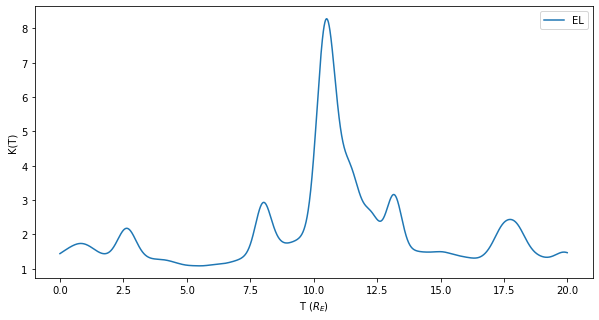

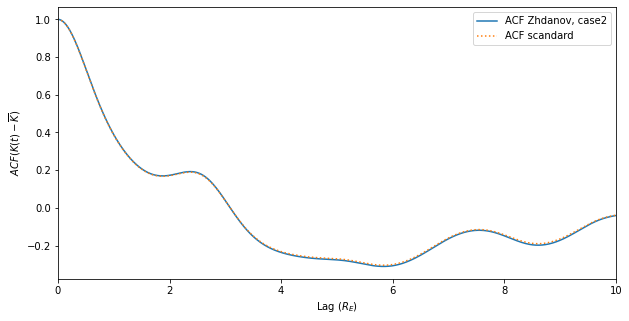

In [7]:

filename2 = "output/e0.7_r0.2/lc_3.00.dat"
lc = get_lc_data(filename2)

tc = lc['t']
sig1 = lc['a_el']

fig = plt.figure(figsize=(10,5))
plt.plot(tc, sig1, '-', label='EL')
plt.xlabel('T ($R_E$)')
plt.ylabel('K(T)')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,5))

x, y = acorr_zh(tc, sig1, avg_substracted=True)
plt.plot(x, y, '-', label='ACF Zhdanov, case2')

y = signal.correlate(sig1 - np.mean(sig1), sig1 - np.mean(sig1))
y /= np.max(y)
x = signal.correlation_lags(len(sig1), len(sig1)) * (tc[1] - tc[0])
plt.plot(x, y, linestyle='dotted', label=("ACF scandard"))


plt.ylabel('$ACF(K(t) - \overline{K})$')
plt.xlabel('Lag ($R_E$)')
plt.xlim([0, 10])
plt.legend()
plt.show()

t=0.00


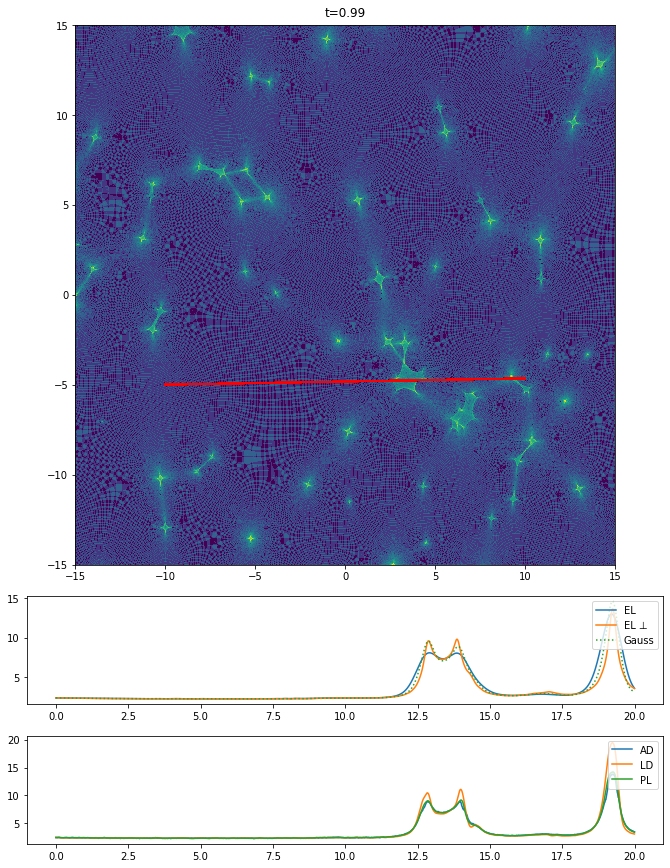

In [211]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [10, 2, 2]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

iterations = np.arange(0, 1, 0.01)

ims = []
max_ampl = []
s_max = 0
for t in iterations:
    if 10 * t % 10 == 0:
        print("t=%.2f" % t)
    filename1 = "output/s0.2_e0.1-0.9_r0.1-0.7_ms/image_%.2f.dat" % t
    filename2 = "output/s0.2_e0.1-0.9_r0.1-0.7_ms/lc_%.2f.dat" % t
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5, 1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='none', extent=extent, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    
    line2, = ax2.plot(lc['t'], lc['el_r0.2_e0.7'],      '-', color=colors[0], label='EL' if t == 0 else None)
    line3, = ax2.plot(lc['t'], lc['el_orth_r0.2_e0.7'], '-', color=colors[1], label='EL ⊥' if t == 0 else None)
    line4, = ax2.plot(lc['t'], lc['gs_r0.2'],      linestyle='dotted', color=colors[2], label='Gauss' if t == 0 else None)
    
    line5, = ax3.plot(lc['t'], lc['ad_r0.2'],     '-', color=colors[0], label='AD' if t == 0 else None)
    line6, = ax3.plot(lc['t'], lc['ld_r0.2'],     '-', color=colors[1], label='LD' if t == 0 else None)
    line7, = ax3.plot(lc['t'], lc['pl_r0.2'],     '-', color=colors[2], label='PL' if t == 0 else None)
    
    _m = max([max(lc[i]) for i in ['ad_r0.2', 'gs_r0.2', 'ld_r0.2', 'pl_r0.2', 'el_r0.2_e0.7', 'el_orth_r0.2_e0.7']])
    s_max = _m if _m > s_max else s_max
    
    ims.append([line1, line2, line3, line4, line5, line6, line7, title])

ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
#for l in ims:
#    _l1, _l3, _l6, _l7, _t = l
#    #_l1, _l2, _l3, _l4, _l5, _l6, _l7, _t = l
#    #_l2.axes.set_ylim([0, 1.05 * s_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images_all.mp4')
plt.show()
plt.close()

t=0.00


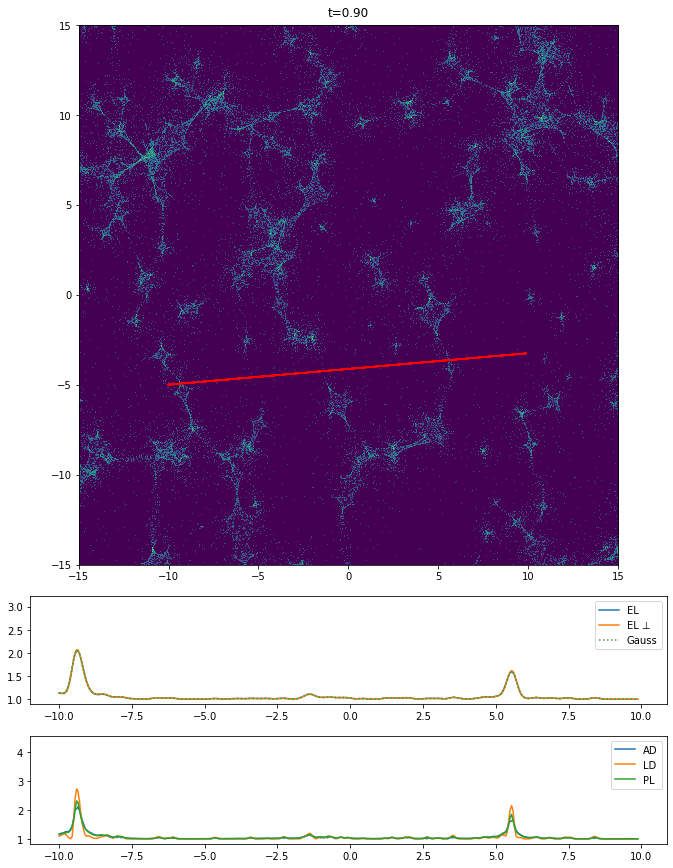

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [10, 2, 2]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

iterations = np.arange(0, 1, 0.1)
directory='reference'

ims = []
max_ampl = []
s_max = 0
for t in iterations:
    if 10 * t % 10 == 0:
        print("t=%.2f" % t)
    filename1 = "output/%s/image_%.2f.dat" % (directory, t)
    filename2 = "output/%s/lc_%.2f.dat" % (directory, t)
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5, 1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='none', extent=extent, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    
    line2, = ax2.plot(lc['y1'], lc['a_el'],      '-', color=colors[0], label='EL' if t == 0 else None)
    line3, = ax2.plot(lc['y1'], lc['a_el_orth'], '-', color=colors[1], label='EL ⊥' if t == 0 else None)
    line4, = ax2.plot(lc['y1'], lc['a_gs'],      linestyle='dotted', color=colors[2], label='Gauss' if t == 0 else None)
    
    line5, = ax3.plot(lc['y1'], lc['a_ad'],     '-', color=colors[0], label='AD' if t == 0 else None)
    line6, = ax3.plot(lc['y1'], lc['a_ld'],     '-', color=colors[1], label='LD' if t == 0 else None)
    line7, = ax3.plot(lc['y1'], lc['a_pl'],     '-', color=colors[2], label='PL' if t == 0 else None)
    
    _m = max([max(lc[i]) for i in ['a_ad', 'a_gs', 'a_ld', 'a_pl', 'a_el', 'a_el_orth']])
    s_max = _m if _m > s_max else s_max
    
    ims.append([line1, line2, line3, line4, line5, line6, line7, title])

ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
#for l in ims:
#    _l1, _l3, _l6, _l7, _t = l
#    #_l1, _l2, _l3, _l4, _l5, _l6, _l7, _t = l
#    #_l2.axes.set_ylim([0, 1.05 * s_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images_all.mp4')
plt.show()
plt.close()

t=0.00


ValueError: Shape of passed values is (402, 310), indices imply (402, 157)

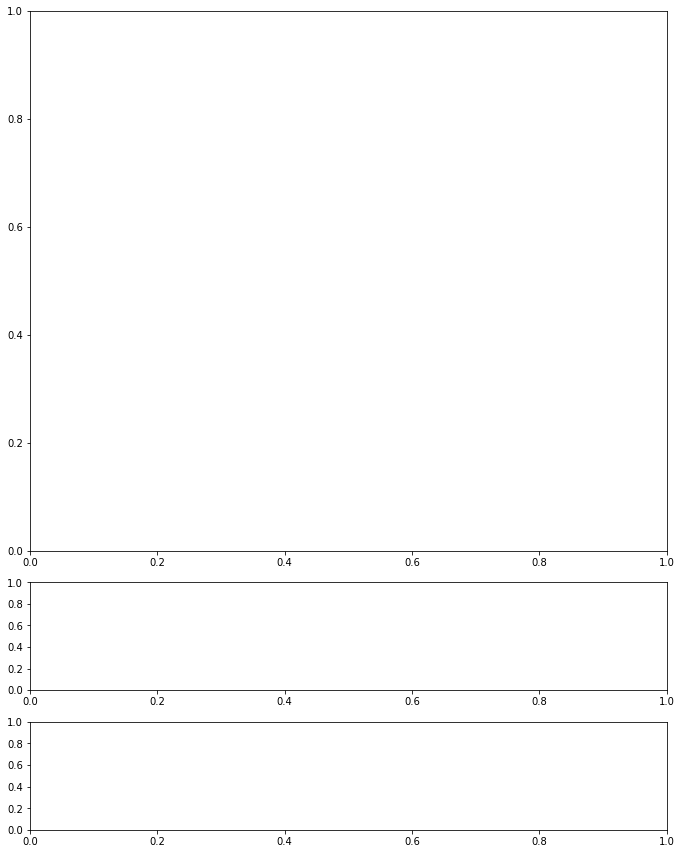

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [10, 2, 2]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

iterations = np.arange(0, 1, 0.1)
directory='reference'

ims = []
max_ampl = []
s_max = 0
for t in iterations:
    if 10 * t % 10 == 0:
        print("t=%.2f" % t)
    filename1 = "output/%s/image_%.2f.dat" % (directory, t)
    filename2 = "output/%s/lc_%.2f.dat" % (directory, t)
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5, 1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='none', extent=extent, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red', linewidth='1')
    
    line2, = ax2.plot(lc['y1'], lc['a_el'],      '-', color=colors[0], label='EL' if t == 0 else None)
    line3, = ax2.plot(lc['y1'], lc['a_el_orth'], '-', color=colors[1], label='EL ⊥' if t == 0 else None)
    line4, = ax2.plot(lc['y1'], lc['a_gs'],      linestyle='dotted', color=colors[2], label='Gauss' if t == 0 else None)
    
    line5, = ax3.plot(lc['y1'], lc['a_ad'],     '-', color=colors[0], label='AD' if t == 0 else None)
    line6, = ax3.plot(lc['y1'], lc['a_ld'],     '-', color=colors[1], label='LD' if t == 0 else None)
    line7, = ax3.plot(lc['y1'], lc['a_pl'],     '-', color=colors[2], label='PL' if t == 0 else None)
    
    _m = max([max(lc[i]) for i in ['a_ad', 'a_gs', 'a_ld', 'a_pl', 'a_el', 'a_el_orth']])
    s_max = _m if _m > s_max else s_max
    
    ims.append([line1, line2, line3, line4, line5, line6, line7, title])

ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
#for l in ims:
#    _l1, _l3, _l6, _l7, _t = l
#    #_l1, _l2, _l3, _l4, _l5, _l6, _l7, _t = l
#    #_l2.axes.set_ylim([0, 1.05 * s_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images_all.mp4')
plt.show()
plt.close()

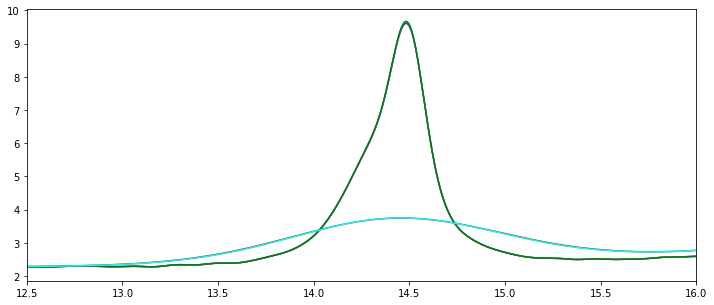

In [206]:
figure = plt.figure(figsize=(12,5))
plt.plot(x['t'], x['el_r0.1_e0.1'], color='blue')
#plt.plot(x['t'], x['el_r0.2_e0.5'], color='grey')
#plt.plot(x['t'], x['el_r0.3_e0.5'], color='grey')
plt.plot(x['t'], x['gs_r0.1'], color='grey')
#plt.plot(x['t'], x['el_r0.5_e0.5'], color='grey')
#plt.plot(x['t'], x['el_r0.6_e0.5'], color='grey')
plt.plot(x['t'], x['el_r0.7_e0.1'], color='red')


plt.plot(x['t'], x['el_orth_r0.1_e0.1'], color='green')
#plt.plot(x['t'], x['el_orth_r0.2_e0.5'], color='yellow')
#plt.plot(x['t'], x['el_orth_r0.3_e0.5'], color='yellow')
#plt.plot(x['t'], x['el_orth_r0.4_e0.5'], color='yellow')
#plt.plot(x['t'], x['el_orth_r0.5_e0.5'], color='yellow')
#plt.plot(x['t'], x['el_orth_r0.6_e0.5'], color='yellow')
plt.plot(x['t'], x['el_orth_r0.7_e0.1'], color='cyan')

plt.xlim([12.5, 16.0])
plt.show()

In [193]:
x.attrs

{'lcs_columns': 157,
 'lcs_t_steps': 2000,
 'lcs_sources': array([0.1  , 0.701, 0.1  ], dtype=float32),
 'lcs_eccentricities': array([0.1  , 0.901, 0.1  ], dtype=float32),
 'lcs': ['ad', 'gs', 'ld', 'pl'],
 'lcs_el': ['el', 'el_orth']}